#Mid Sem code
#Vignesh Ramakrishnan 
#21310037
#ME639

In [2]:
#Vignesh Ramakrishnan
#21310037
#Importing libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate 
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import HTML
from numpy import sin, cos,arctan,arccos
from collections import deque

In [17]:

#Rotational matrix along x
def RotX(theta):
  theta=np.radians(theta)
  return np.array([[1,0,0,0],[0,np.cos(theta),-np.sin(theta),0],[0,np.sin(theta),np.cos(theta),0],[0,0,0,1]])


#Rotational matrix along y
def RotY(theta):
  theta=np.radians(theta)
  return np.array([[np.cos(theta),0,-np.sin(theta),0],[0,1,0,0],[np.sin(theta),0,np.cos(theta),0],[0,0,0,1]])


#Rotational matrix along z
def RotZ(theta):
  theta=np.radians(theta)
  return np.array([[np.cos(theta),-np.sin(theta),0,0],[np.sin(theta),np.cos(theta),0,0],[0,0,1,0],[0,0,0,1]])


#Translational matrix along x
def TransX(dist):
  return np.array([[1,0,0,dist],[0,1,0,0],[0,0,1,0],[0,0,0,1]])

#Translational matrix along y
def TransY(dist):
  return np.array([[1,0,0,0],[0,1,0,dist],[0,0,1,0],[0,0,0,1]])

#Translational matrix along z
def TransZ(dist):
  return np.array([[1,0,0,0],[0,1,0,0],[0,0,1,dist],[0,0,0,1]])
 
#[d,theta,a,alpha]
def AFromDHVals(DH):
  n=np.shape(DH)[0] #From repo, only this index
  A=np.identity(4)
  for i in range(n):
    Anext=TransZ(DH[i][0]) @ RotZ(DH [i][1]) @ RotX(DH [i][3]) @ TransX(DH[i][2]) 
    A=np.matmul(A,Anext)
  return A
#DH=[[0,90,1,0],[0,45,1,0]]
#print(AFromDHVals(DH))



[[-0.70710678 -0.70710678  0.         -0.70710678]
 [ 0.70710678 -0.70710678  0.          1.70710678]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


In [129]:
#Repository Jacobian1

import numpy as np
import sys
import sympy as sym

class manipulator():

  def __init__(self, no_of_links, type_of_joints, dh_params):
    super().__init__()
    self.no_of_links = no_of_links
    self.type_of_joints = list(type_of_joints)
    self.dh_params = dh_params
    if len(self.dh_params) != self.no_of_links:
      print("ERROR: Please make sure the number of rows in the DH parameters provided is equal to the number of links.")
      sys.exit()
    self.dh_matrices = []
    for i in range(0, self.no_of_links):    
      temp = self.dh_params[i]
      theta = temp[0]
      d = temp[1]
      a = temp[2]
      alpha = temp[3]
      A1 = np.array([[np.cos(theta), -np.sin(theta), 0, 0],[np.sin(theta), np.cos(theta), 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]])
      A2 = np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, d],[0, 0, 0, 1]])
      A3 = np.array([[1, 0, 0, a],[0, 1, 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]])
      A4 = np.array([[1, 0, 0, 0],[0, np.cos(alpha), -np.sin(alpha), 0],[0, np.sin(alpha), np.cos(alpha), 0],[0, 0, 0, 1]])
      A_final = A1@A2@A3@A4
      self.dh_matrices.append(A_final)
    self.dh_matrices = np.array(self.dh_matrices)

    self.transform_matrices = []
    self.rotation_matrices = []

    for i in range(1, self.no_of_links+1):
      temp = self.dh_matrices[0]
      for j in range(1, i):
        temp = temp@self.dh_matrices[j]
      rot_temp = temp
      rot_temp = np.delete(rot_temp, (3), axis = 0)
      rot_temp = np.delete(rot_temp, (3), axis = 1)
      self.transform_matrices.append(temp)
      self.rotation_matrices.append(rot_temp)

    self.transform_matrices = np.array(self.transform_matrices)
    self.rotation_matrices = np.array(self.rotation_matrices)

    self.end_effector_posn = np.delete(self.transform_matrices[len(self.transform_matrices)-1]@np.array([[0],[0],[0],[1]]), (3), axis = 0)

    self.z = []
    self.origins = []
    self.z.append(np.array([[0],[0],[1]]))
    self.origins.append(np.array([[0],[0],[0]]))

    for i in range(0, self.no_of_links):
      temp_z = self.rotation_matrices[i]@np.array([[0],[0],[1]])
      self.z.append(temp_z)
      temp_origin = self.transform_matrices[i]@np.array([[0],[0],[0],[1]])
      temp_origin = np.delete(temp_origin, (3), axis = 0)
      self.origins.append(temp_origin)
    
    self.z = np.array(self.z)
    self.origins = np.array(self.origins)  
    self.jacobian = []
    for i in range(0,self.no_of_links):
      if self.type_of_joints[i] == "R":
        temp_1 = np.cross(self.z[i], self.end_effector_posn-self.origins[i], axis = 0)
        temp_2 = self.z[i]
      if self.type_of_joints[i] == "P":
        temp_1 = self.z[i]
        temp_2 = np.array([[0],[0],[0]])
      temp_jacobian = np.vstack((temp_1, temp_2))
      self.jacobian.append(temp_jacobian)
    self.jacobian = np.array(self.jacobian)
    self.jacobian = self.jacobian.reshape((self.no_of_links,6))
    self.jacobian = np.transpose(self.jacobian)
    self.Jv = np.delete(self.jacobian,(3,4,5), axis = 0)

    print("End Effector Position:")
    print(self.end_effector_posn)
    print("Manipulator Jacobian:")
    print(self.jacobian)
    print("Velocity Jacobian (can be multiplied with qdot to obtain end-effector velocity):")
    print(self.Jv)

my_robot = manipulator(3, "RRR", [[np.pi/3,0,1,0],[0,0,0,np.pi/2],[0,0,0,np.pi/2]])
print("STANFORD MANIPULATOR:")
stanford_manipulator = manipulator(3, "RRP", [[0,0,0,-np.pi/2],[0,2,0,np.pi/2],[0,2,0,0]])
print("SCARA MANIPULATOR:")
SCARA = manipulator(3, "RRP", [[0,0,2,0],[0,0,2,np.pi],[0,2,0,0]])
print("PPP MANIPULATOR:")
PPP = manipulator(3, "PPP", [[0,1,0,-np.pi/2],[-np.pi/2,2,0,-np.pi/2],[0,3,0,0]])
print("6R MANIPULATOR:")
R6 = manipulator(6, "RRRRRR", [[np.pi/2,1,0,-np.pi/2],[0,0,1,0],[0,0,1,np.pi/2],[0,0,0,np.pi/2],[0,0,0,-np.pi/2],[0,1,0,0]])

End Effector Position:
[[0.5      ]
 [0.8660254]
 [0.       ]]
Manipulator Jacobian:
[[-8.66025404e-01  0.00000000e+00 -0.00000000e+00]
 [ 5.00000000e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  8.66025404e-01]
 [ 0.00000000e+00  0.00000000e+00 -5.00000000e-01]
 [ 1.00000000e+00  1.00000000e+00  6.12323400e-17]]
Velocity Jacobian (can be multiplied with qdot to obtain end-effector velocity):
[[-0.8660254  0.        -0.       ]
 [ 0.5        0.         0.       ]
 [ 0.         0.         0.       ]]
STANFORD MANIPULATOR:
End Effector Position:
[[0.]
 [2.]
 [2.]]
Manipulator Jacobian:
[[-2.000000e+00  2.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  1.000000e+00  0.000000e+00]
 [ 1.000000e+00  6.123234e-17  0.000000e+00]]
Velocity Jacobian (can be multiplied with qdot to obtain end-

# Task 1: Milacron manifold block inspection

In [87]:
Linklengths=[0.25,0.25,0.25]
Linkmasses=[0.8,0.8,0.8]
Amax=[0.45,0.075,0.1]
Bmax=[0.45,-0.075,0.1]
Cmax=[0.25,0.075,0.1]
Dmax=[0.25,-0.075,0.1]

#### Robot 1: Stanford type(RRP)


In [253]:
#Forward Kinematics i.e. end effector positions from joint positions
def For_Pos_Kin_Stanford(jointloc,lengthsoflinks):
  theta1,theta2,dz3=jointloc[0],jointloc[1],jointloc[2]
  d1,d2,d3=lengthsoflinks[0],lengthsoflinks[1],lengthsoflinks[2]
  DH=[[d1,theta1,0,-90],[d2,theta2,0,90],[-dz3,0,0,0]]  
  P0=np.array([0,0,0,1])
  A=AFromDHVals(DH)
  res=A @ P0
  return res[0:3]
For_Pos_Kin_Stanford([0,0,0.15],[0.25,0,0.25])

array([0. , 0. , 0.1])

In [255]:
def For_Pos_Kin_Stanford_NoDH(jointloc,lengthsoflinks):
  theta1,theta2,dy2=jointloc[0],jointloc[1],jointloc[2]
  l1,l2,l3=lengthsoflinks[0],lengthsoflinks[1],lengthsoflinks[2]
  P2mat = np.transpose(np.array([0,dy2,0,1]))
  P1mat=((RotX(theta2) @ TransX(-l2)) @ P2mat)
  P0mat=((RotZ(theta1) @ TransZ(l1)) @ P1mat)
  return P0mat[0:3]
For_Pos_Kin_Stanford_NoDH([0,0,0.15],[0.25,0,0.25])

array([0.  , 0.15, 0.25])

In [263]:

#inverse kinematics i.e. joint positions from endeffector positions: My Code from spong 
def Inv_Pos_Kin_Stanford(P0,lengthsoflinks):
  P_x=P0[0]
  P_y=P0[1]
  P_z=P0[2]
  l_1,l_2=lengthsoflinks[0],lengthsoflinks[1]
  r= ((P_x**2) + (P_y**2))**0.5 #revolute link radius
  phi= np.arctan2(P_y,P_x) # revolute link angle
 
  theta_1=np.arctan2(P_x,P_y)- np.arctan2(l_2,((r**2)-(l_2**2))**0.5 ) # theta_1=np.arctan2(P_x,P_y)- np.arctan2(l_2,-((r**2)-(l_2**2))**0.5 ) # also valid

  
  theta_1_v2=np.arctan2(P_x,P_y)- np.arctan2(l_2,-((r**2)-(l_2**2))**0.5 )
    

  l_hor=((P_x*np.cos(theta_1))+(P_y*np.sin(theta_1))) #Horizontal position of joint 2
  l_vert=l_1-P_z #Vertical position of joint 2



  theta_2=np.arctan2(l_hor,l_vert) #  theta_2=np.arctan2(-l_hor,-l_vert) #also valid

  #if theta_2 < 0 :
  theta_2_v2=np.arctan2(-l_hor,-l_vert)
  
  d_3= (l_hor* np.sin(theta_2))+(l_vert* np.cos(theta_2))
  return [[np.degrees(theta_1),np.degrees(theta_2),d_3],[np.degrees(theta_1_v2),np.degrees(theta_2_v2),d_3]]

#Inv_Pos_Kin_Stanford(Amax,[0.25,0.25,0.5])

#For_Pos_Kin_Stanford_NoDH([0.25,0.25,0.5])


jointloc=Inv_Pos_Kin_Stanford(Amax,[0.25,0.25,0.5])
print(jointloc)
print(For_Pos_Kin_Stanford_NoDH(jointloc[1],[0.25,0.25,0.5]))


[[47.30799649413152, 67.3943310604584, 0.3902320599631367], [-66.23264091018274, -112.6056689395416, 0.3902320599631367]]
[-0.23803441  0.16834376 -0.11025139]


In [256]:
 #From Repository
def invKinStanford_RepoCode(endeffector_position,lengthsoflinks):
    theta1 = np.arctan(endeffector_position[1]/endeffector_position[0])
    r = np.sqrt(endeffector_position[0]**2 + endeffector_position[1]**2)
    s = endeffector_position[2] - lengthsoflinks[0]
    theta2 = np.arctan(s/r)
    d3 = np.sqrt(r**2 + s**2) - lengthsoflinks[1]
    #print("First Solution: \n", "Theta1 = ", theta1, "\n Theta2 =", theta2,"\n Extension: ", d3, "\n")
    #print("Second Solution: \n", "Theta1 = ", np.pi + theta1, "\n Theta2 =", np.pi - theta2,"\n Extension:", d3)
    return [[theta1,theta2,d3],[np.pi + theta1,np.pi - theta2,d3]]
          

jointloc=inverse_kinematics([30,30,30],[10,10])
For_Pos_Kin_Stanford_NoDH(jointloc[1],[10,10,10])

array([-16.5329107 ,  30.67504632,  25.73598567])

#### Robot 2: PUMA type(RRR)

In [215]:
#Forward Kinematics i.e. end effector positions from joint positions
def For_Pos_Kin_PUMA(jointloc,lengthsoflinks):
  theta1,theta2,theta3=jointloc[0],jointloc[1],jointloc[2]
  d1,d2,d3=lengthsoflinks[0],lengthsoflinks[1],lengthsoflinks[2]
  DH=[[d1,theta1,0,0],[0,theta2,d2,-90],[0,theta3,d3,0]]
  P0=np.array([0,0,0,1])
  A=AFromDHVals(DH)
  res=A @ P0
  return res[0:3]

In [216]:
 #From Repo
 def Inv_Pos_Kin_PUMA(P0,lengthsoflinks):
   xc,yc,zc=P0[0],P0[1],P0[2]
   l1,l2,l3=lengthsoflinks[0],lengthsoflinks[1],lengthsoflinks[2]
   theta1 = np.rad2deg(np.arctan2(yc,xc))
   D = (xc*xc+yc*yc+(zc-l1)*(zc-l1)-l2*l2-l3*l3)/(2*l2*l3)
   if D>=1 or D<=-1:
     print("singular configuration")
   if D>1 or D<-1:
     print("outside workspace")
   theta3 = (np.arctan2((-np.sqrt(1-D*D)),D))
   theta2 = np.rad2deg(np.arctan2(zc-l1,(np.sqrt(xc*xc+yc*yc)))-np.arctan2((l3*np.sin(theta3)),(l2+l3*np.cos(theta3))))
   theta3 = np.rad2deg(theta3)
   return [[theta1,theta2,theta3]]

print(Inv_Pos_Kin_PUMA([0.45,0.075,0.1],Linklengths))
jointloc=Inv_Pos_Kin_PUMA([0.45,0.075,0.1],Linklengths)
print(For_Pos_Kin_PUMA(jointloc[0],Linklengths))

[[9.462322208025617, -2.0367282034521836, -32.328064122162274]]
[0.45738174 0.05961129 0.38369158]


#### Robot 3: SCARA type(RRP)

In [217]:
def For_Pos_Kin_SCARA(jointloc,lengthsoflinks):
  theta1,theta2,dz3=jointloc[0],jointloc[1],jointloc[2]
  d1,d2,d3=lengthsoflinks[0],lengthsoflinks[1],lengthsoflinks[2]
  DH=[[d1,theta1,d2,0],[0,theta2,d3,0],[-dz3,0,0,0]]
  P0=np.array([0,0,d1-dz3,1])
  A=AFromDHVals(DH)
  res=A @ P0
  return res[0:3]



In [218]:
 #Inverse Kinematics of SCARA from my old code
 def Inv_Pos_Kin_SCARA(P0,lengthsoflinks):
   l_1=lengthsoflinks[0]
   l_2=lengthsoflinks[1]
   h=lengthsoflinks[2]
   P_x=P0[0]
   P_y=P0[1]
   P_z=P0[2]
   theta_2=np.arccos(((P_x**2+P_y**2)-(l_1**2+l_2**2))/(2*l_1*l_2)) # + or -
   theta_1=np.arctan2(((l_2*P_x*np.sin(theta_2))+P_y*(l_1+l_2*np.cos(theta_2))),(-(l_2*P_y*np.sin(theta_2))+P_x*(l_1+l_2*np.cos(theta_2))))
   d_3=h-P_z
   print()
   return np.array([[np.degrees(theta_1),np.degrees(theta_2),d_3],[np.degrees(theta_1),np.degrees(-theta_2),d_3]])

print(Inv_Pos_Kin_SCARA([0.5,0,0],Linklengths))
jointloc=Inv_Pos_Kin_SCARA([0.5,0,0],Linklengths)
print(For_Pos_Kin_SCARA(jointloc[0],Linklengths))


[[ 0.    0.    0.25]
 [ 0.   -0.    0.25]]

[0.5 0.  0. ]


## Task 1a

In [258]:
Linklengths=[0.25,0.25,0.25]
Linkmasses=[0.8,0.8,0.8]
Amax=[0.45,0.075,0.1]
Bmax=[0.45,-0.075,0.1]
Cmax=[0.25,0.075,0.1]
Dmax=[0.25,-0.075,0.1]

#Calculating required link lengths
def StanfordLinkLengthReqd(Amax,Bmax,Cmax,Dmax):
  l1new=max(0.25,abs(Amax[2]),abs(Bmax[2]),abs(Cmax[2]),abs(Dmax[2]))
  l2new=max(0.25,abs(Amax[1]-Bmax[1]),abs(Cmax[1]-Dmax[1]))
  l3new=( ((l1new-max(abs(Amax[2]),abs(Bmax[2]),abs(Cmax[2]),abs(Dmax[2])))**2+ (max(abs(Amax[1]-Bmax[1]),abs(Cmax[1]-Dmax[1]))))**2 + max(0.25,abs(Amax[0]),abs(Bmax[0]),abs(Cmax[0]),abs(Dmax[0]))**2)**0.5
  return [l1new,l2new,l3new]
print('Stanford Link lengths required:',StanfordLinkLengthReqd(Amax,Bmax,Cmax,Dmax))
lstan=StanfordLinkLengthReqd(Amax,Bmax,Cmax,Dmax)



def SCARALinkLengthReqd(Amax,Bmax,Cmax,Dmax):
  l1new=max(0.25,abs(Amax[2]),abs(Bmax[2]),abs(Cmax[2]),abs(Dmax[2]))
  l2new=(max(0.25,abs(Amax[1]-Bmax[1]),abs(Cmax[1]-Dmax[1])))
  l3new=max(0.5*(((max(abs(Amax[1]-Bmax[1]),abs(Cmax[1]-Dmax[1])))**2 + max(abs(Amax[0]),abs(Bmax[0]),abs(Cmax[0]),abs(Dmax[0]))**2-l2new**2)**0.5),0.25)
  return [l1new,l2new,l3new]
print('SCARA Link lengths required:',SCARALinkLengthReqd(Amax,Bmax,Cmax,Dmax))
lScara=SCARALinkLengthReqd(Amax,Bmax,Cmax,Dmax)




def PUMALinkLengthReqd(Amax,Bmax,Cmax,Dmax):
  l1new=max(0.25,abs(Amax[2]),abs(Bmax[2]),abs(Cmax[2]),abs(Dmax[2]))
  l2new=(max(0.25,abs(Amax[1]-Bmax[1]),abs(Cmax[1]-Dmax[1])))
  l3new=max(0.25,0.5*((max(abs(Amax[1]-Bmax[1]),abs(Cmax[1]-Dmax[1])))**2 + max(abs(Amax[0]),abs(Bmax[0]),abs(Cmax[0]),abs(Dmax[0]))**2+(l1new-max(abs(Amax[2]),abs(Bmax[2]),abs(Cmax[2]),abs(Dmax[2])))**2-l2new**2)**0.5)
  return [l1new,l2new,l3new]
print('PUMA Link lengths required:',PUMALinkLengthReqd(Amax,Bmax,Cmax,Dmax))
lPUMA=PUMALinkLengthReqd(Amax,Bmax,Cmax,Dmax)

#Verification for Stanford max values
print('Amax',Amax)
jointloc=invKinStanford_RepoCode(Amax,lstan)
print('Joint variables for Stanford',jointloc)
print('Verifying for Stanford Amax',For_Pos_Kin_Stanford_NoDH(jointloc[1],lstan))

print('Bmax',Bmax)
jointloc=invKinStanford_RepoCode(Bmax,lstan)
print('Joint variables for Stanford',jointloc)
print('Verifying for Stanford ',For_Pos_Kin_Stanford_NoDH(jointloc[0],lstan))

print('Cmax',Cmax)
jointloc=invKinStanford_RepoCode(Cmax,lstan)
print('Joint variables for Stanford',jointloc)
print('Verifying for Stanford Cmax',For_Pos_Kin_Stanford_NoDH(jointloc[0],lstan))

print('Dmax',Dmax)
jointloc=invKinStanford_RepoCode(Dmax,lstan)
print('Joint variables for Stanford',jointloc)
print('Verifying for Stanford Dmax',For_Pos_Kin_Stanford_NoDH(jointloc[0],lstan))

#Verification for SCARA max values

jointloc=(Inv_Pos_Kin_SCARA(Amax,lScara))
print('Amax',Amax)
print('Joint variables for SCARA',jointloc)
print('Verifying Amax for SCARA',For_Pos_Kin_SCARA(jointloc[0],lScara))


jointloc=(Inv_Pos_Kin_SCARA(Bmax,lScara))
print('Bmax',Bmax)
print('Joint variables for SCARA',jointloc)
print('Verifying Bmax for SCARA',For_Pos_Kin_SCARA(jointloc[0],lScara))

jointloc=(Inv_Pos_Kin_SCARA(Cmax,lScara))
print('Cmax',Cmax)
print('Joint variables for SCARA',jointloc)
print('Verifying Cmax for SCARA',For_Pos_Kin_SCARA(jointloc[0],lScara))

jointloc=(Inv_Pos_Kin_SCARA(Dmax,lScara))
print('Dmax',Dmax)
print('Joint variables for SCARA',jointloc)
print('Verifying Dmax for SCARA',For_Pos_Kin_SCARA(jointloc[0],lScara))

#Verification for PUMA(Articulated) max values
jointloc=Inv_Pos_Kin_PUMA(Amax,lPUMA)
print('Amax',Amax)
print('Joint variables for PUMA',jointloc)
print('Verifying Amax for PUMA',For_Pos_Kin_PUMA(jointloc[0],lPUMA))

jointloc=Inv_Pos_Kin_PUMA(Bmax,lPUMA)
print('Bmax',Bmax)
print('Joint variables for PUMA',jointloc)
print('Verifying Bmax for PUMA',For_Pos_Kin_PUMA(jointloc[0],lPUMA))

jointloc=Inv_Pos_Kin_PUMA(Cmax,lPUMA)
print('Cmax',Cmax)
print('Joint variables for PUMA',jointloc)
print('Verifying Cmax for PUMA',For_Pos_Kin_PUMA(jointloc[0],lPUMA))

jointloc=Inv_Pos_Kin_PUMA(Dmax,lPUMA)
print('Dmax',Dmax)
print('Joint variables for PUMA',jointloc)
print('Verifying Dmax for PUMA',For_Pos_Kin_PUMA(jointloc[0],lPUMA))



Stanford Link lengths required: [0.25, 0.25, 0.48192971479252034]
SCARA Link lengths required: [0.25, 0.25, 0.25]
PUMA Link lengths required: [0.25, 0.25, 0.25]
Amax [0.45, 0.075, 0.1]
Joint variables for Stanford [[0.16514867741462683, -0.3176631929822606, 0.23023431780746362], [3.30674133100442, 3.4592558465720535, 0.23023431780746362]]
Verifying for Stanford Amax [-0.26283982  0.21501182  0.26389205]
Bmax [0.45, -0.075, 0.1]
Joint variables for Stanford [[-0.16514867741462683, -0.3176631929822606, 0.23023431780746362], [2.976443976175166, 3.4592558465720535, 0.23023431780746362]]
Verifying for Stanford  [-0.24933535  0.23095042  0.24872353]
Cmax [0.25, 0.075, 0.1]
Joint variables for Stanford [[0.2914567944778671, -0.5216056136891403, 0.051039864469807406], [3.4330494480676603, 3.6631982672789336, 0.051039864469807406]]
Verifying for Stanford Cmax [-0.25025639  0.04976537  0.24953535]
Dmax [0.25, -0.075, 0.1]
Joint variables for Stanford [[-0.2914567944778671, -0.5216056136891403, 0

## Task 1b

In [222]:
lstan=StanfordLinkLengthReqd(Amax,Bmax,Cmax,Dmax)
lScara=SCARALinkLengthReqd(Amax,Bmax,Cmax,Dmax)
lPUMA=PUMALinkLengthReqd(Amax,Bmax,Cmax,Dmax)
A=[0.3,0.02,0.2]
B=[0.3,-0.02,0.2]
C=[0.22,0.02,0.2]
D=[0.22,-0.02,0.2]

def verify(A,B,C,D):
  #For Stanford
  print('A',A)
  jointloc=invKinStanford_RepoCode(A,lstan)
  print('Joint variables for Stanford',jointloc)
  print('Verifying for Stanford A',For_Pos_Kin_Stanford(jointloc[0],lstan))
  print('B',B)
  jointloc=invKinStanford_RepoCode(B,lstan)
  print('Joint variables for Stanford',jointloc)
  print('Verifying for Stanford ',For_Pos_Kin_Stanford(jointloc[0],lstan))
  print('C',C)
  jointloc=invKinStanford_RepoCode(C,lstan)
  print('Joint variables for Stanford',jointloc)
  print('Verifying for Stanford C',For_Pos_Kin_Stanford(jointloc[0],lstan))
  print('D',D)
  jointloc=invKinStanford_RepoCode(D,lstan)
  print('Joint variables for Stanford',jointloc)
  print('Verifying for Stanford D',For_Pos_Kin_Stanford(jointloc[0],lstan))
  #For SCARA
  jointloc=(Inv_Pos_Kin_SCARA(A,lScara))
  print('A',A)
  print('Joint variables for SCARA',jointloc)
  print('Verifying A for SCARA',For_Pos_Kin_SCARA(jointloc[0],lScara))


  jointloc=(Inv_Pos_Kin_SCARA(B,lScara))
  print('B',B)
  print('Joint variables for SCARA',jointloc)
  print('Verifying B for SCARA',For_Pos_Kin_SCARA(jointloc[0],lScara))

  jointloc=(Inv_Pos_Kin_SCARA(C,lScara))
  print('Cmax',C)
  print('Joint variables for SCARA',jointloc)
  print('Verifying C for SCARA',For_Pos_Kin_SCARA(jointloc[0],lScara))

  jointloc=(Inv_Pos_Kin_SCARA(D,lScara))
  print('D',D)
  print('Joint variables for SCARA',jointloc)
  print('Verifying D for SCARA',For_Pos_Kin_SCARA(jointloc[0],lScara))

  #Verification for PUMA(Articulated)  values
  jointloc=Inv_Pos_Kin_PUMA(A,lPUMA)
  print('A',A)
  print('Joint variables for PUMA',jointloc)
  print('Verifying A for PUMA',For_Pos_Kin_PUMA(jointloc[0],lPUMA))

  jointloc=Inv_Pos_Kin_PUMA(B,lPUMA)
  print('B',B)
  print('Joint variables for PUMA',jointloc)
  print('Verifying B for PUMA',For_Pos_Kin_PUMA(jointloc[0],lPUMA))

  jointloc=Inv_Pos_Kin_PUMA(C,lPUMA)
  print('C',C)
  print('Joint variables for PUMA',jointloc)
  print('Verifying C for PUMA',For_Pos_Kin_PUMA(jointloc[0],lPUMA))

  jointloc=Inv_Pos_Kin_PUMA(D,lPUMA)
  print('D',D)
  print('Joint variables for PUMA',jointloc)
  print('Verifying D for PUMA',For_Pos_Kin_PUMA(jointloc[0],lPUMA))



verify(A,B,C,D)
  




A [0.3, 0.02, 0.2]
Joint variables for Stanford [[0.06656816377582381, -0.1647894923382187, 0.054795013082563404], [3.208160817365617, 3.306382145928012, 0.054795013082563404]]
Verifying for Stanford A [-1.32861677e-04  2.50000014e-01  1.95205214e-01]
B [0.3, -0.02, 0.2]
Joint variables for Stanford [[-0.06656816377582381, -0.1647894923382187, 0.054795013082563404], [3.0750244898139694, 3.306382145928012, 0.054795013082563404]]
Verifying for Stanford  [0.00044806 0.24999965 0.19520521]
C [0.22, 0.02, 0.2]
Joint variables for Stanford [[0.09065988720074511, -0.22258890308619653, -0.02350496694187751], [3.232252540790538, 3.3641815566759896, -0.02350496694187751]]
Verifying for Stanford C [-0.00048689  0.24999954  0.27350479]
D [0.22, -0.02, 0.2]
Joint variables for Stanford [[-0.09065988720074511, -0.22258890308619653, -0.02350496694187751], [3.050932766389048, 3.3641815566759896, -0.02350496694187751]]
Verifying for Stanford D [0.00030426 0.24999983 0.27350479]

A [0.3, 0.02, 0.2]
Join

## Task 1c


In [225]:
A = [0.40, 0.06, 0.1]
B = [0.40, 0.01, 0.1] 
C = [0.35, 0.01, 0.1]
D =[0.35, 0.06,0.1]
verify(A,B,C,D)

A [0.4, 0.06, 0.1]
Joint variables for Stanford [[0.14888994760949725, -0.3551283547555233, 0.18139309220245986], [3.2904826011992903, 3.4967210083453164, 0.18139309220245986]]
Verifying for Stanford A [0.00047464 0.25000208 0.06861039]
B [0.4, 0.01, 0.1]
Joint variables for Stanford [[0.024994793618920156, -0.3586679747243447, 0.17731721238443], [3.1665874472087134, 3.500260628314138, 0.17731721238443]]
Verifying for Stanford  [0.00100093 0.25000046 0.07268626]
C [0.35, 0.01, 0.1]
Joint variables for Stanford [[0.028563657838759998, -0.4047440841038663, 0.13091993909481814], [3.170156311428553, 3.546336737693659, 0.13091993909481814]]
Verifying for Stanford C [0.00080019 0.25000043 0.11908333]
D [0.35, 0.06, 0.1]
Joint variables for Stanford [[0.16977827396833844, -0.3996744581806758, 0.13548670534792762], [3.311370927558132, 3.541267111770469, 0.13548670534792762]]
Verifying for Stanford D [2.04297636e-04 2.50001703e-01 1.14516591e-01]

A [0.4, 0.06, 0.1]
Joint variables for SCARA [[

## Task 1d

## Task 1e

#Task 3

##Task 3b

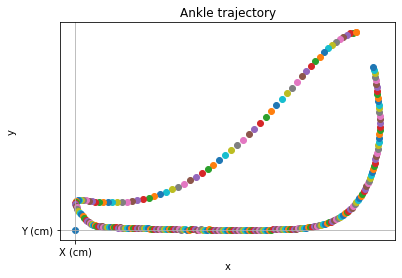

In [178]:
import xlrd
loc = ("/content/drive/MyDrive/Colab Notebooks/Gait_DATA.xlsx")
 
wb = xlrd.open_workbook(loc)
sheet = wb.sheet_by_index(0)
for i in range(sheet.nrows):
  p=sheet.row_values(i)
  plt.scatter(p[0],p[1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ankle trajectory')
plt.grid()
plt.show()

## Task 3c

# Task 4

## Task 4c

In [232]:

#Repo code for D and V calculation
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
numberoflinks=1
# Creating Class Robot and defining functions
class Robot():
  def __init__(self, numberoflinks, D_q, V_q):
    self.numberoflinks = numberoflinks
    self.D_q = D_q
    self.V_q = V_q

  def derive_equations(self):
    Phi = [0] * self.numberoflinks # Creating phi matrix
    c = [[[0] * self.numberoflinks] * self.numberoflinks] * self.numberoflinks # Creating c matrix
    T = [0] * self.numberoflinks # Matrix to store torque values for each link
    d = 0
    ct = 0

    # Calculating Christoffer Symbols
    for k in range(self.numberoflinks):
      for j in range(self.numberoflinks):
        for i in range(self.numberoflinks):
          c[i][j][k] = 0.5 * (sp.diff(self.D_q[k][j], q[i]) + sp.diff(self.D_q[k][i], q[j]) - sp.diff(self.D_q[i][j], q[k]))
    
    for k in range(self.numberoflinks): #corresponds to each link
      Phi[k] = sp.diff(self.V_q, q[k])
      for j in range(self.numberoflinks):
        d = d + self.D_q[k][j] * qddot[j] 
        for i in range(self.numberoflinks):
          ct = ct + c[i][j][k] * qdot[i] * qdot[j]
      T[k] = d + ct + Phi[k]

    for i in range(self.numberoflinks):
      print('T' + str(i+1) + ' = ' + str(T[i]))

# Preparing arrays of terms to accept valid input
q = []
qdot = []
qddot = []
for i in range(1000):
  q.append(sp.symbols('q' + str(i + 1)))
  qdot.append(sp.symbols('q"' + str(i + 1)))
  qddot.append(sp.symbols('q""' + str(i + 1)))

# Initializing object robot with input [numberoflinks, D_q, V_q]
robot = Robot(1, [[5, 15 * sp.cos(q[1] - q[0])], [15 * sp.cos(q[0] - q[0]), 10]], 13 * sp.sin(q[0]) + 45 * (5 * sp.sin(q[0]) + 3 * sp.sin(q[0])))
robot.derive_equations()

T1 = 5*q""1 + 373*cos(q1)


In [228]:
#Repo code
def forwarddynamicscontrol(m1, m2, l1, l2, xd, yd, prev_state):
    # g = 0 in case of robot in horizontal plane
    g = 9.81
    q1 = prev_state[0][0]
    print("q1",q1)
    q2 = prev_state[1][0]
    print("q2",q2)
    q1dot = prev_state[2][0]
    q2dot = prev_state[3][0]
    d11 = (m1 * ((l1/2)** 2) + m2 * (l1 ** 2) + m1*(l1**2)/3)
    d12 = m2 * (l1 * (l2/2) * np.cos(q2 - q1))
    d21 = m2 * (l1 * (l2/2) * np.cos(q2 - q1))
    d22 = m2 * (l2/2 ** 2) +  m1*(l1**2)/3
    D = np.array([[d11, d12], [d21, d22]])
    C = np.array([[-m2 * l1 * (l2/2) * np.sin(q2 - q1) * ((q2dot) ** 2) ],
                  [m2 * l1 * (l2/2) * np.sin(q2 - q1) * (q1dot) ** 2]], dtype=float)
    V = np.array([[(m1*(l1/2)+m2*l1) * g * np.cos(q1)], [m2 * g * (l2/2) * np.cos(q2)]],
                 dtype=float)
    gain = np.array([[10,0],[0,10]])
    #x1,y1,x,y = forward_kinematics(np.pi/4,np.pi/4,l1,l2)
    q1d,q2d = inverse_kinematics(xd,yd,l1,l2,elbow)
    print(q1d,q2d)
    X = np.array([[q1],[q2]])
    Xd = np.array([[q1d],[q2d]])
    Qdot = np.array([[q1dot],[q2dot]])
    gain2 = np.array([[0.1,0],[0,0.1]])
    tau = C+V+np.matmul(gain,Xd-X)-0*np.matmul(gain2,Qdot)
    detinv = (1 / ((D[0][0]) * (D[1][1]) - ((D[0][1]) * (D[1][0]))))
    di11 = detinv * D[1][1]
    di12 = -1 * detinv * D[0][1]
    di21 = -1 * detinv * D[1][0]
    di22 = detinv * D[0][0]
    Dinv = np.array([[di11, di12], [di21, di22]])
    # print(Dinv)
    sum = -C - V + tau
    qddot = np.matmul(Dinv, sum)
    qdot = np.array([[q1dot], [q2dot]])
    print(qdot)
    statedot = np.row_stack([qdot, qddot])
    return statedot

In [227]:
#Integrator from Repo
def runge_kutta_fourth_order(f, ut, prev_state, t0, tn, h, m1, m2, l1, l2):
    X = np.zeros([prev_state.shape[0], int((tn - t0) / h) + 1])
    X[:][0] = prev_state[:][0]
    t = t0
    i = 0
    time = np.zeros([1, int((tn - t0) / h) + 1])
    time[0][0] = t0
    while t <= tn:
        xd = ut[0][i]
        yd = ut[1][i]
        # print(prev_state)
        k1 = f(m1, m2, l1, l2, xd, yd, prev_state)
        t = t + h / 2
        k2 = f(m1, m2, l1, l2, xd, yd, (prev_state + (k1 * h / 2)))
        k3 = f(m1, m2, l1, l2, xd, yd, prev_state + (k2 * h / 2))
        t = t + h / 2
        k4 = f(m1, m2, l1, l2, xd, yd, prev_state + (k3 * h))
        k = (k1 + 2 * k2 + 2 * k3 + k4) / 6
        x_new = prev_state + k * h
        # print(x_new)
        # store the result of integration for each time step as a column in X
        X[:, i] = x_new[:, 0]
        print(np.shape(x_new))
        i = i + 1
        print(np.shape(prev_state))
        prev_state = x_new

        # print("i",i)
    return X